In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import pickle
from time import time
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Input

Using TensorFlow backend.


In [2]:
captions=[]
with open("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt") as f:
    captions= f.read()

captions= captions.split('\n')[:-1]
print((captions[0]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [3]:
descriptions={}
for x in captions:
    first , second = x.split('\t')
    image_name= first.split('.')[0]
    
    if descriptions.get(image_name) is None:
        descriptions[image_name]=[]
    descriptions[image_name].append(second)
        

In [4]:

print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


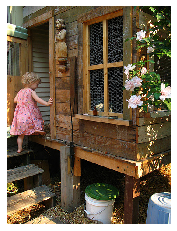

In [5]:
Path='Flickr_Data/Flickr_Data/Images/'
import cv2

image= cv2.imread(Path+'1000268201_693b08cb0e.jpg')
image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)

In [6]:
def clean_data(sentence):
    sentence=sentence.lower()
    sentence= re.sub('[^a-z]+'," ",sentence)
    print(sentence)
    sentence=sentence.split()
    
    sentence= [s for s in sentence if len(s)>1 ]
    sentence= " ".join(sentence)
    return sentence

In [7]:
sentence= clean_data(' A car has 2 headlights')

 a car has headlights


In [8]:
print((sentence))

car has headlights


In [ ]:
for key , captions in descriptions.items():
    for i in range(len(captions)):
        captions[i]= clean_data(captions[i])
        
print(descriptions['1000268201_693b08cb0e'])        

In [10]:
with open('descriptions_1.txt','w') as f:
    f.write(str(descriptions))

In [11]:
with open('descriptions_1.txt') as f:
    file_data= f.read()

In [12]:
json_acceptable_string= file_data.replace("'","\"")
descriptions= json.loads(json_acceptable_string)

In [13]:
print(descriptions['1000268201_693b08cb0e'])        

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [14]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print(len(vocab))

8424


In [15]:
total_words=[]
for key , captions in descriptions.items():
     [total_words.append(s) for desc in captions for s in desc.split()]
print(len(total_words))

373837


In [16]:
import collections

counter = collections.Counter(total_words)
freq_cnt= dict(counter)
print(len(freq_cnt.keys()))

8424


In [17]:
sorted_freq_cnt= sorted(freq_cnt.items(),reverse=True,key= lambda x:x[1])

threshold= 10
freq_cnt_sorted=[x for x in sorted_freq_cnt if x[1]>threshold ]
total_words=[x[0] for x in freq_cnt_sorted]
print(len(total_words))

1845


In [18]:
with open("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as f:
    train_text_data=f.read()
with open("Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
    test_text_data=f.read()


In [19]:
train_image= [row.split('.')[0] for row in train_text_data.split('\n')[:-1]]
test_image= [row.split('.')[0] for row in test_text_data.split('\n')[:-1]]

In [20]:
train={}
for img_id in train_image:
    train[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append= "startseq "+cap+" endseq"
        train[img_id].append(cap_to_append)

In [21]:
test={}
for img_id in test_image:
    test[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append= "startseq "+cap+" endseq"
        test[img_id].append(cap_to_append)

In [23]:
from keras.layers import *
from keras.models import *
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

In [ ]:
model = ResNet50( weights='imagenet',input_shape=(224,224,3))
model.summary()

In [25]:
model_new= Model(model.input, model.layers[-2].output)

In [26]:
def preprocess_image(img):
    img= image.load_img(img, target_size=(224,224))
    img= image.img_to_array(img)
    img= np.expand_dims(img,axis=0)
    #normalization
    img= preprocess_input(img)
    return img
 

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


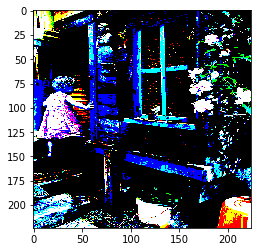

In [27]:
img= preprocess_image(Path+'1000268201_693b08cb0e.jpg')
img= img[0]
plt.imshow(img)

In [28]:
def encode_image(img):
    img= preprocess_image(img)
    features_array=model_new.predict(img)
    features_array= features_array.reshape((-1,))
    #print(features_array.shape)
    return features_array

In [29]:
encode_image(Path+'1000268201_693b08cb0e.jpg')

array([0.04154286, 0.17076087, 0.2927856 , ..., 0.05089605, 0.31322372,
       0.8600747 ], dtype=float32)

In [30]:
start= time()
encoded_vector={}
for ix, img_id in enumerate(train):
    img_path= Path+img_id+".jpg"
    encoded_vector[img_id]= encode_image(img_path)
    
    if ix%100==0:
        print('encoding in process time stamp %d'%ix)
end= time()
print("total time=",end-start)

encoding in process time stamp 0
encoding in process time stamp 100
encoding in process time stamp 200
encoding in process time stamp 300
encoding in process time stamp 400
encoding in process time stamp 500
encoding in process time stamp 600
encoding in process time stamp 700
encoding in process time stamp 800
encoding in process time stamp 900
encoding in process time stamp 1000
encoding in process time stamp 1100
encoding in process time stamp 1200
encoding in process time stamp 1300
encoding in process time stamp 1400
encoding in process time stamp 1500
encoding in process time stamp 1600
encoding in process time stamp 1700
encoding in process time stamp 1800
encoding in process time stamp 1900
encoding in process time stamp 2000
encoding in process time stamp 2100
encoding in process time stamp 2200
encoding in process time stamp 2300
encoding in process time stamp 2400
encoding in process time stamp 2500
encoding in process time stamp 2600
encoding in process time stamp 2700
enco

In [31]:
!mkdir saved

In [32]:
with open("saved/encoded_train_images.pkl",'wb') as f:
    pickle.dump(encoded_vector,f)

In [ ]:
start= time()
to_encode_vector={}
for ix, img_id in enumerate(test):
    img_path= Path+img_id+".jpg"
    to_encode_vector[img_id]= encode_image(img_path)
    
    if ix%100==0:
        print('encoding in process time stamp %d'%ix)
end= time()
print("total test encode time=",end-start)
with open("saved/encoded_test_images.pkl",'wb') as f:
    pickle.dump(to_encode_vector,f)

encoding in process time stamp 0
encoding in process time stamp 100
encoding in process time stamp 200
encoding in process time stamp 300
encoding in process time stamp 400
encoding in process time stamp 500
encoding in process time stamp 600
encoding in process time stamp 700
encoding in process time stamp 800
encoding in process time stamp 900


In [35]:
with open("saved/encoded_test_images.pkl",'wb') as f:
    pickle.dump(to_encode_vector,f)

In [ ]:
encoded_vector

In [37]:
max_len=0
for key in train.keys():
    for cap in train[key]:
        max_len=max(max_len, len(cap.split()))

In [38]:
print (max_len)

35


In [39]:
word_to_idx={}
idx_to_word={}
for i,x in enumerate(total_words):
    word_to_idx[x]=i+1
    idx_to_word[i+1]=x
    

In [40]:
print(len(word_to_idx))

1845


In [41]:
idx_to_word[6]

'dog'

In [42]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

In [43]:
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

In [44]:
idx_to_word[1847]

'endseq'

In [45]:
vocab_size=len(idx_to_word)+1
print(vocab_size)

1848


In [46]:
def data_preparation(max_len, train, word_to_idx,vocab_size,encoded_vector, batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key , desc_list in train.items():
            n+=1
        
            image= encoded_vector[key]
            for desc in desc_list:
                seq= [word_to_idx[x] for x in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi= seq[0:i]
                    yi= seq[i]
                
                    xi= pad_sequences([xi],maxlen=max_len, value=0,padding='post')[0]
                    yi= to_caategorical([yi],num_classes=vocab_size)[0]
                
                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y=[],[],[]
                    n=0

In [56]:
f= open('glove.6B.50d.txt', encoding='utf-8')

In [57]:
embedding_idx={}

for line in f:
    values= line.split()
    word= values[0]
    embedding=np.array(values[1:], dtype='float')
    embedding_idx[word]= embedding
embedding_idx['apple']
f.close()

In [ ]:
embedding_idx['apple']

In [49]:
def get_embedding_matrix():
    matrix= np.zeros((vocab_size,50))
    for word, idx in word_to_idx.items():
        embedding= embedding_idx.get(word)
        
        if embedding is not None:
            matrix[idx]= embedding
    return matrix

    

In [50]:
embedding_matrix= get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [53]:
embedding_matrix[1]

array([ 0.33042  ,  0.24995  , -0.60874  ,  0.10923  ,  0.036372 ,
        0.151    , -0.55083  , -0.074239 , -0.092307 , -0.32821  ,
        0.09598  , -0.82269  , -0.36717  , -0.67009  ,  0.42909  ,
        0.016496 , -0.23573  ,  0.12864  , -1.0953   ,  0.43334  ,
        0.57067  , -0.1036   ,  0.20422  ,  0.078308 , -0.42795  ,
       -1.7984   , -0.27865  ,  0.11954  , -0.12689  ,  0.031744 ,
        3.8631   , -0.17786  , -0.082434 , -0.62698  ,  0.26497  ,
       -0.057185 , -0.073521 ,  0.46103  ,  0.30862  ,  0.12498  ,
       -0.48609  , -0.0080272,  0.031184 , -0.36576  , -0.42699  ,
        0.42164  , -0.11666  , -0.50703  , -0.027273 , -0.53285  ])

In [54]:
input_img_features= Input(shape=(2048,))
input_img1= Dropout(0.3)(input_img_features)
input_img2= Dense(256,activation='relu')(input_img1)

In [58]:
input_captions= Input(shape=(max_len,))
inp_cap1= Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2= Dropout(0.3)(inp_cap1)
inp_cap3= LSTM(256)(inp_cap2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [59]:
decoder1= add([input_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

modelF= Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [60]:
modelF.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [73]:
mkdir model_weights


In [61]:
modelF.layers[2].set_weights([embedding_matrix])
modelF.layers[2].trainable=False
modelF.compile(loss= 'categorical_crossentropy', optimizer='adam')

In [ ]:
epochs=20
batch_size=3
steps= len(train)/batch_size

def train_data():
    
    for i in range(epochs):
        generator= data_preparation(max_len, train, word_to_idx,vocab_size,encoded_vector, batch_size)
        modelF.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        modelF.save('./model_weights/model_'+str(i)+'.h5')
train_data()

In [63]:
model= load_model('./model_9.h5')

In [65]:
def predict_captions(photo):
    in_text='startseq'
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx ]
        sequence= pad_sequences([sequence], maxlen=max_len,padding='post')
        
        ypred= model.predict([photo,sequence])
        ypred= ypred.argmax()
        word= idx_to_word[ypred]
        in_text+=(' '+word)
        
        if word=='endseq':
            break

    final_caption= in_text.split()[1:-1]
    final_caption= " ".join(final_caption)
    return final_caption


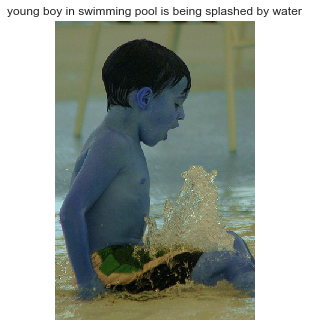

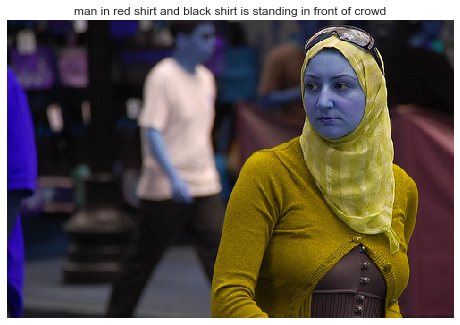

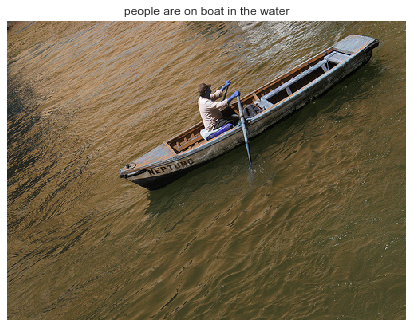

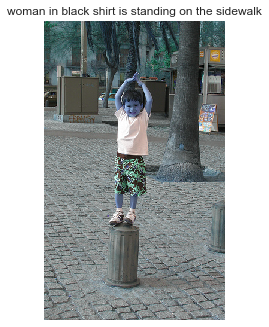

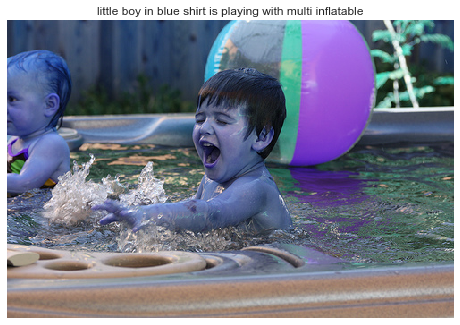

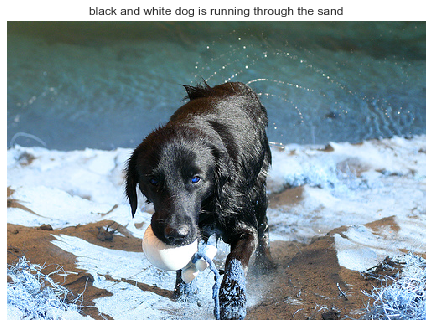

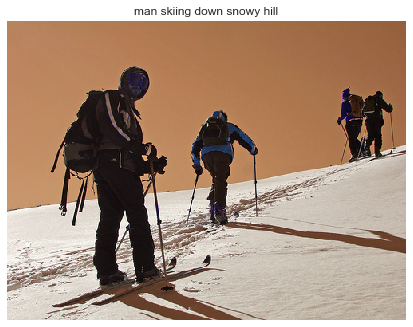

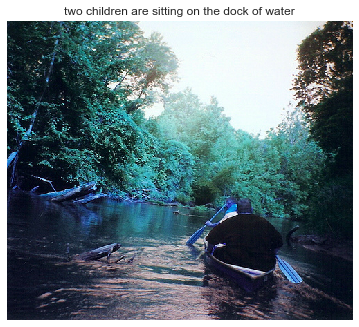

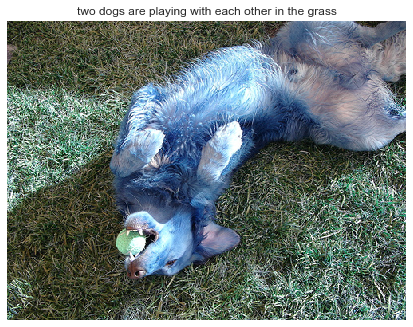

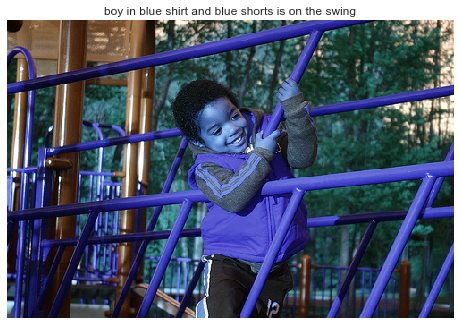

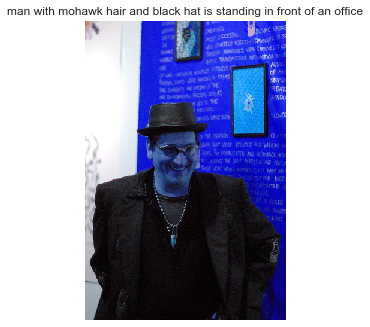

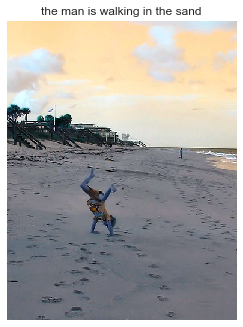

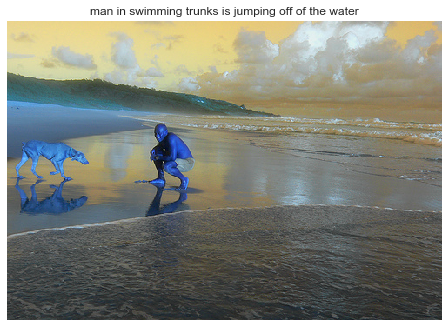

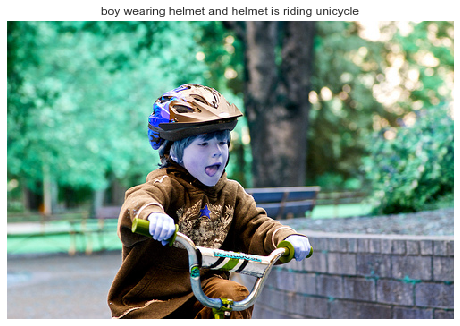

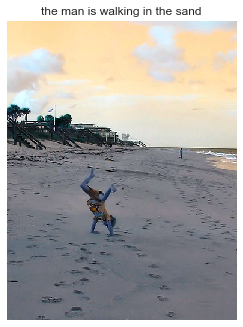

In [79]:
import cv2
plt.style.use('seaborn')

for i in range(15):
    idx= np.random.randint(0,1000)
    all_images_names= list(to_encode_vector.keys())
    image_name=all_images_names[idx]
    photo_2048= to_encode_vector[image_name].reshape((1,2048))
    ima=cv2.imread(Path+image_name+'.jpg')
    
    caption = predict_captions(photo_2048)
    plt.title(caption)
    plt.imshow(ima)
    plt.axis('off')
    plt.show()

In [76]:
print(len(train))

6000
